In [1]:
import os
from tqdm import tqdm
import json
import argparse
import pickle
import torch
import torch.nn as nn
import numpy as np
import pprint
from tensorboardX import SummaryWriter
import re
import gc
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from numpy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D

sys.path = ['..'] + sys.path
from algorithm_trainer.models import gated_conv_net_original, resnet, resnet_2, resnet_12, conv64
from algorithm_trainer.algorithm_trainer import Generic_adaptation_trainer, Classical_algorithm_trainer
from algorithm_trainer.algorithms.algorithm import SVM, ProtoNet, Finetune
from algorithm_trainer.utils import accuracy
from data_layer.dataset_managers import MetaDataManager, ClassicalDataManager
from analysis.objectives import var_reduction_disc, var_reduction_disc_perp, var_reduction

%matplotlib inline

# evaluations

In [2]:
def load_model(model, checkpoint):
    print(f"loading from {checkpoint}")
    model_dict = model.state_dict()
    chkpt_state_dict = torch.load(checkpoint)
    if 'model' in chkpt_state_dict:
        chkpt_state_dict = chkpt_state_dict['model']
    chkpt_state_dict_cpy = chkpt_state_dict.copy()
    # remove "module." from key, possibly present as it was dumped by data-parallel
    for key in chkpt_state_dict_cpy.keys():
        if 'module.' in key:
            new_key = re.sub('module\.', '',  key)
            chkpt_state_dict[new_key] = chkpt_state_dict.pop(key)
    chkpt_state_dict = {k: v for k, v in chkpt_state_dict.items() if k in model_dict}
    model_dict.update(chkpt_state_dict)
    updated_keys = set(model_dict).intersection(set(chkpt_state_dict))
    missed_keys = set(model_dict).difference(set(chkpt_state_dict))
    print(f"Missed {len(missed_keys)} keys")
    model.load_state_dict(model_dict)
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    model.cuda()
    return model

In [ ]:
image_size = 84
batch_size = 2
n_way = 5
n_shot = 1
n_query = 15
n_episodes = 400
dataset_path = '../data/filelists/miniImagenet'
chkpt = '../train_dir/metal_MI_r12_n60_s5_q5_euc/classical_resnet_015.pt'
model = resnet_12.resnet12(avg_pool=True, drop_rate=0.1, dropblock_size=5, no_fc_layer=True, projection=False)
model = load_model(model, chkpt)

algorithm = ProtoNet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot=n_shot,
    n_query=n_query,
    device='cuda')

adaptation_trainer = Generic_adaptation_trainer(
    algorithm=algorithm,
    aux_objective=None,
    outer_loss_func=torch.nn.CrossEntropyLoss(),
    outer_optimizer=None, 
    writer=None,
    log_interval=150,
    model_type='resnet12'
)

val_file = os.path.join(dataset_path, 'novel.json')
meta_val_datamgr = MetaDataManager(
    image_size, batch_size=batch_size, n_episodes=n_episodes,
    n_way=n_way, n_shot=n_shot, n_query=n_query)
meta_val_loader = meta_val_datamgr.get_data_loader(val_file, aug=False)
adaptation_trainer.run(meta_val_loader, meta_val_datamgr)

# 1-d interpolation

In [24]:
def evaluate(model, dataset, parameters, split):
    image_size = parameters['image_size']
    batch_size = 1
    n_way = parameters[split]['n_way']
    n_shot = parameters[split]['n_shot']
    n_query = parameters[split]['n_query']
    n_episodes = 100
    dataset_path = f"../data/filelists/{dataset}"
    
    algorithm = ProtoNet(
        model=model,
        inner_loss_func=torch.nn.CrossEntropyLoss(),
        n_way=n_way,
        n_shot=n_shot,
        n_query=n_query,
        device='cuda')

    adaptation_trainer = Generic_adaptation_trainer(
        algorithm=algorithm,
        aux_objective=None,
        outer_loss_func=torch.nn.CrossEntropyLoss(),
        outer_optimizer=None, 
        writer=None,
        log_interval=1500,
        model_type='resnet12'
    )

    if split == 'train':
        file = os.path.join(dataset_path, 'base.json')
    else:
        file = os.path.join(dataset_path, 'novel.json')
    
    meta_datamgr = MetaDataManager(
        image_size, batch_size=batch_size, n_episodes=500,
        n_way=n_way, n_shot=n_shot, n_query=n_query)
    meta_loader = meta_datamgr.get_data_loader(file, support_aug=False, query_aug=False)
    return adaptation_trainer.run(meta_loader, meta_datamgr)['test_loss_after']['loss']


def moving_average(net1, net2, net, alpha=1):
    for param, param1, param2 in zip(net.parameters(), net1.parameters(), net2.parameters()):
        param.data = (1.0 - alpha) * param1.data + alpha * param2.data
    return net


def _check_bn(module, flag):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        flag[0] = True


def check_bn(model):
    flag = [False]
    model.apply(lambda module: _check_bn(module, flag))
    return flag[0]


def reset_bn(module):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        module.running_mean = torch.zeros_like(module.running_mean)
        module.running_var = torch.ones_like(module.running_var)


def _get_momenta(module, momenta):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        momenta[module] = module.momentum


def _set_momenta(module, momenta):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        module.momentum = momenta[module]


def bn_update(loader, model):
    """
        BatchNorm buffers update (if any).
        Performs 1 epochs to estimate buffers average using train dataset.
        :param loader: train dataset loader for buffers average estimation.
        :param model: model being update
        :return: None
    """
    if not check_bn(model):
        return
    model.train()
    momenta = {}
    model.apply(reset_bn)
    model.apply(lambda module: _get_momenta(module, momenta))
    n = 0
    for input, _ in loader:
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        b = input_var.data.size(0)

        momentum = b / (n + b)
        for module in momenta.keys():
            module.momentum = momentum

        model(input_var)
        n += b

    model.apply(lambda module: _set_momenta(module, momenta))

In [25]:
def plot_loss(model_0, model_1, model, dataset, parameters, loader, eta=0.05, alpha_st=-0.2, alpha_end=1.2):

      
    metrics = defaultdict(list)
    for alpha in np.arange(alpha_st, alpha_end, eta):
        with torch.no_grad():
            model = moving_average(model_0, model_1, model, eta)
            bn_update(loader, model)
            metrics['train'].append(evaluate(model, dataset, parameters, split='train'))
            metrics['test'].append(evaluate(model, dataset, parameters, split='test'))
            print("alpha",  alpha, metrics['train'][-1], metrics['test'][-1])
        
    return metrics

In [14]:
parameters = {
    'image_size': 84,
    'train': {
        'n_way': 64,
        'n_shot': 5,
        'n_query': 5
    },
    'test': {
        'n_way': 5,
        'n_shot': 5,
        'n_query': 15 
    }
}  
dataset = 'miniImagenet'

dataset_path = f"../data/filelists/{dataset}"
file = os.path.join(dataset_path, 'base.json')    
cl_datamgr = ClassicalDataManager(parameters['image_size'], batch_size=128)
loader = cl_datamgr.get_data_loader(file, aug=False)


chkpt = '../train_dir/metal_MI_r12_n60_s5_q5_euc/classical_resnet_020.pt'
model_fixS = resnet_12.resnet12(avg_pool=True, drop_rate=0.1, dropblock_size=5, no_fc_layer=True, projection=False)
model_fixS = load_model(model_fixS, chkpt)
chkpt = '../train_dir/metal_MI_r12_n64_s3_q128_ML/classical_resnet_120.pt'
model_meta = resnet_12.resnet12(avg_pool=True, drop_rate=0.1, dropblock_size=5, no_fc_layer=True, projection=False)
model_meta = load_model(model_meta, chkpt)
model = resnet_12.resnet12(avg_pool=True, drop_rate=0.1, dropblock_size=5, no_fc_layer=True, projection=False)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.cuda()

metrics = plot_loss(model_fixS, model_meta, model, 'miniImagenet', parameters, loader)

Unit norm projection is  False
loading from ../train_dir/metal_MI_r12_n60_s5_q5_euc/classical_resnet_020.pt
Missed 0 keys
Unit norm projection is  False
loading from ../train_dir/metal_MI_r12_n64_s3_q128_ML/classical_resnet_120.pt
Missed 4 keys
Unit norm projection is  False
n_way: 64, n_shot: 5, n_query: 5, batch_sz: 1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 1
alpha -0.2 4.154905759811402 1.6090115864276886
n_way: 64, n_shot: 5, n_query: 5, batch_sz: 1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 1
alpha -0.15000000000000002 4.154874011039734 1.6090160603523254
n_way: 64, n_shot: 5, n_query: 5, batch_sz: 1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 1
alpha -0.10000000000000003 4.1548966178894045 1.609009463071823
n_way: 64, n_shot: 5, n_query: 5, batch_sz: 1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 1
alpha -0.050000000000000044 4.15491074180603 1.609015154838562
n_way: 64, n_shot: 5, n_query: 5, batch_sz: 1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 1
alpha -5.551115123125783e

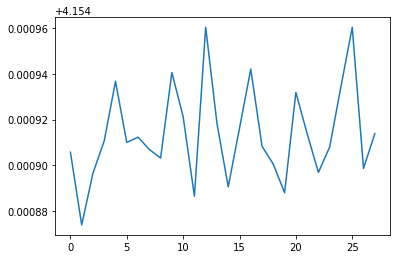

In [21]:
import seaborn as sns
plt.plot(metrics['train'])

## model

In [ ]:
model = resnet_2.ResNet18(
    num_classes=64,  
    add_bias=False, 
    no_fc_layer=False,
    classifier_type='linear'
)


checkpoint = '../train_dir/classical_miniimagenet_dc_bn_with_rfc_var_ortho/classical_resnet_147.pt'
print(f"loading from {checkpoint}")
model_dict = model.state_dict()
chkpt_state_dict = torch.load(checkpoint)
if 'model' in chkpt_state_dict:
    chkpt_state_dict = chkpt_state_dict['model']
chkpt_state_dict_cpy = chkpt_state_dict.copy()
# remove "module." from key, possibly present as it was dumped by data-parallel
for key in chkpt_state_dict_cpy.keys():
    if 'module.' in key:
        new_key = re.sub('module\.', '',  key)
        chkpt_state_dict[new_key] = chkpt_state_dict.pop(key)
chkpt_state_dict = {k: v for k, v in chkpt_state_dict.items() if k in model_dict}
model_dict.update(chkpt_state_dict)
updated_keys = set(model_dict).intersection(set(chkpt_state_dict))
print(f"Updated {len(updated_keys)} keys using chkpt")
print("Following keys updated :", "\n".join(sorted(updated_keys)))
missed_keys = set(model_dict).difference(set(chkpt_state_dict))
print(f"Missed {len(missed_keys)} keys")
print("Following keys missed :", "\n".join(sorted(missed_keys)))
model.load_state_dict(model_dict)
        
        
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.cuda()
model.eval()

In [ ]:
model_dc = resnet_2.ResNet18(
    num_classes=64,  
    no_fc_layer=False,
    classifier_type='ortho-classifier'
)


checkpoint = '../train_dir/classical_miniimagenet_dc_bn_ldim/classical_resnet_137.pt'
print(f"loading from {checkpoint}")
model_dict = model_dc.state_dict()
chkpt_state_dict = torch.load(checkpoint)
if 'model' in chkpt_state_dict:
    chkpt_state_dict = chkpt_state_dict['model']
chkpt_state_dict_cpy = chkpt_state_dict.copy()
# remove "module." from key, possibly present as it was dumped by data-parallel
for key in chkpt_state_dict_cpy.keys():
    if 'module.' in key:
        new_key = re.sub('module\.', '',  key)
        chkpt_state_dict[new_key] = chkpt_state_dict.pop(key)
chkpt_state_dict = {k: v for k, v in chkpt_state_dict.items() if k in model_dict}
model_dict.update(chkpt_state_dict)
updated_keys = set(model_dict).intersection(set(chkpt_state_dict))
print(f"Updated {len(updated_keys)} keys using chkpt")
print("Following keys updated :", "\n".join(sorted(updated_keys)))
missed_keys = set(model_dict).difference(set(chkpt_state_dict))
print(f"Missed {len(missed_keys)} keys")
print("Following keys missed :", "\n".join(sorted(missed_keys)))
model_dc.load_state_dict(model_dict)
        
        
model_dc = torch.nn.DataParallel(model_dc, device_ids=range(torch.cuda.device_count()))
model_dc.cuda()
model_dc.eval()

## dataset

In [ ]:
image_size = 224
dataset_path = '../data/filelists/miniImagenet'
val_file = os.path.join(dataset_path, 'val.json')
train_file = os.path.join(dataset_path, 'base.json')
classical_val_datamgr = ClassicalDataManager(image_size, batch_size=16)
classical_val_loader = classical_val_datamgr.get_data_loader(val_file, aug=False)
classical_train_datamgr = ClassicalDataManager(image_size, batch_size=16)
classical_train_loader = classical_val_datamgr.get_data_loader(train_file, aug=False)

## utils

In [ ]:
def get_features(model, dataloader):
    iterator = tqdm(dataloader)
    features = defaultdict(list)
    for batch in iterator:
        batch_x, batch_y = batch
        batch_x = batch_x.cuda()
        batch_y = batch_y.cpu().numpy()
        features_x = model(batch_x, features_only=True)
        for y in np.unique(batch_y):
            features[y].append(features_x[batch_y==y].detach().cpu().numpy())
    for key in features:
        features[key] = np.concatenate(features[key], axis=0) 
        print(f"Received {features[key].shape} for class {key}")
    return features

## adhoc anmalysis

In [ ]:
# val_features = get_features(model, classical_val_loader)
train_features = get_features(model, classical_train_loader)

In [ ]:
val_features_dc = get_features(model_dc, classical_val_loader)
train_features_dc = get_features(model_dc, classical_train_loader)

In [ ]:
for x in range(64, 80):
    A = val_features_dc[x] / np.linalg.norm(val_features_dc[x]+0.00001, axis=1)[:, None]
    print(x, (A @ A.T).mean(), (A @ A.T).var())

In [ ]:
for x in range(0, 64):
    A = train_features_dc[x] / np.linalg.norm(train_features_dc[x]+0.00001, axis=1)[:, None]
    print(x, (A @ A.T).mean(), (A @ A.T).var())

In [ ]:
sum(np.cumsum(PCA().fit(val_features_dc[65]).explained_variance_ratio_) < 0.8) + 1

In [ ]:
np.linalg.svd(val_features_dc[69])[1]

In [ ]:
avg = []
for x in range(64, 80):
    plt.plot(np.cumsum(PCA().fit(val_features_dc[x] / np.linalg.norm(val_features_dc[x], axis=1)[:, None]).explained_variance_ratio_[:10]), label='train', color='blue')
    avg.append(sum(np.cumsum(PCA().fit(val_features_dc[x] / np.linalg.norm(val_features_dc[x], axis=1)[:, None]).explained_variance_ratio_) < 0.8) + 1)
print(np.mean(avg))
# for x in range(0, 64):
#     plt.plot(np.cumsum(PCA().fit(train_features_dc[x]).explained_variance_ratio_[:10]), label='train_dc', color='green')
# plt.legend()

In [ ]:
[(x, PCA().fit(train_features_dc[10]).components_[0] @ model_dc.module.fc.L.weight_v[x].detach().cpu().numpy()) for x in range(64)]

In [ ]:
max(pairwise_distances(
    PCA().fit(val_features_dc[65]).components_,
    PCA().fit(val_features_dc[66]).components_,
    metric='cosine'
)[0])

In [ ]:
plt.plot(np.cumsum(PCA().fit(val_features[71]).explained_variance_ratio_[:30]), label='val')
plt.plot(np.cumsum(PCA().fit(train_features[40]).explained_variance_ratio_[:30]), label='train')
plt.legend()

## checking linear seperability

In [ ]:
feature_set = val_features_dc
dim = feature_set[list(feature_set.keys())[0]].shape[1]

In [ ]:
class SimpleDataset:    
    def __init__(self, features):
        self.features = np.concatenate([features[x] for x in features], axis=0)
        self.target = np.repeat(np.arange(len(features)), features[list(features.keys())[0]].shape[0])

    def __getitem__(self, i):
        return self.features[i], self.target[i]
    
    def __len__(self):
        return len(self.features)

In [ ]:
dataset = SimpleDataset(feature_set)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
# model
M = torch.nn.Linear(dim, len(feature_set))
torch.nn.init.xavier_uniform_(M.weight)
M = M.cuda()
loss_layer = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(M.parameters(), lr=0.001)
# train
for epoch in range(1000):
    for i, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.cuda()
#         batch_x = batch_x / (torch.norm(batch_x, dim=1, p=2, keepdim=True) + 0.00001)
        batch_y = batch_y.cuda()
        logits = M(batch_x)
        loss = loss_layer(logits, batch_y)
        loss.backward()
        if i % 1000 == 0:
            print(f"epoch: {epoch} iter : {i} loss : {loss.item()}, accuracy: {accuracy(logits, batch_y) * 100.}")
        optimizer.step()

In [ ]:
accu = []
loss = []
for i, (batch_x, batch_y) in enumerate(loader):
    batch_x = batch_x.cuda()
    batch_x = batch_x / (torch.norm(batch_x, dim=1, p=2, keepdim=True) + 0.00001)
    batch_y = batch_y.cuda()
    with torch.no_grad():
        logits = M(batch_x)
        loss.append(loss_layer(logits, batch_y).item())
        accu.append(accuracy(logits, batch_y) * 100.)
print(np.mean(accu), np.mean(loss))

# dimensionality analysis

In [ ]:
feature_set = val_features_dc
dim = feature_set[list(feature_set.keys())[0]].shape[1]
n_classes = len(feature_set)
low_dim = 20
label_offset = 64

In [ ]:
class Projector(torch.nn.Module):
    
    def __init__(self, backbone, dim, low_dim, n_classes):
        super().__init__()
        self.backbone = backbone
        self.backbone.eval()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(dim, low_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(low_dim, low_dim),
            torch.nn.Linear(low_dim, n_classes, bias=False)
        )
#         torch.nn.init.xavier_normal_(self.mlp.weight)
            
    def forward(self, x, features_only=False):
        if features_only:
            return self.mlp[:-1](self.backbone(x, features_only=True).detach()) 
        return self.mlp(self.backbone(x, features_only=True).detach())

In [ ]:
model = resnet_2.ResNet18(
    num_classes=64,  
    no_fc_layer=True
)

checkpoint = '../train_dir/classical_miniimagenet_dc_bn_with_var_ortho_scale_test/classical_resnet_217.pt'
print(f"loading from {checkpoint}")
model_dict = model.state_dict()
chkpt_state_dict = torch.load(checkpoint)
if 'model' in chkpt_state_dict:
    chkpt_state_dict = chkpt_state_dict['model']
chkpt_state_dict_cpy = chkpt_state_dict.copy()
# remove "module." from key, possibly present as it was dumped by data-parallel
for key in chkpt_state_dict_cpy.keys():
    if 'module.' in key:
        new_key = re.sub('module\.', '',  key)
        chkpt_state_dict[new_key] = chkpt_state_dict.pop(key)
chkpt_state_dict = {k: v for k, v in chkpt_state_dict.items() if k in model_dict}
model_dict.update(chkpt_state_dict)
updated_keys = set(model_dict).intersection(set(chkpt_state_dict))
print(f"Updated {len(updated_keys)} keys using chkpt")
print("Following keys updated :", "\n".join(sorted(updated_keys)))
missed_keys = set(model_dict).difference(set(chkpt_state_dict))
print(f"Missed {len(missed_keys)} keys")
print("Following keys missed :", "\n".join(sorted(missed_keys)))
model.load_state_dict(model_dict)
        
projector = Projector(model, dim, low_dim, n_classes)
projector = torch.nn.DataParallel(projector, device_ids=range(torch.cuda.device_count()))
projector.cuda()

In [ ]:
image_size = 224
dataset_path = '../data/filelists/miniImagenet'
val_file = os.path.join(dataset_path, 'val.json')
classical_val_datamgr = ClassicalDataManager(image_size, batch_size=32)
classical_val_loader = classical_val_datamgr.get_data_loader(val_file, aug=False)
loss_layer = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(projector.module.mlp.parameters(), lr=0.001)
lambda_epoch = lambda e: 1.0 if e < 50  else 0.1
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda_epoch, last_epoch=-1)
    
for epoch in range(1000):
    avg_loss = []
    avg_accu = []
    iterator = enumerate(classical_val_loader)
    for i, batch in iterator:
        optimizer.zero_grad()
        batch_x, batch_y = batch
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y = batch_y - label_offset
        logits = projector(batch_x)
        loss = loss_layer(logits, batch_y)
        loss.backward()
        optimizer.step()
        avg_loss.append(loss.item())
        avg_accu.append(accuracy(logits, batch_y) * 100.)
        if i % 1000 == 0:
            print(f"epoch: {epoch} iter: {i} loss : {np.mean(avg_loss)}, accuracy: {np.mean(avg_accu)}")
        if epoch % 5 == 0:
            with open(f"models/projector_{epoch}.pt", 'wb') as f:
                torch.save(projector.state_dict(), f)
    lr_scheduler.step()

In [ ]:
A = val_features_dc[65]

In [ ]:
pc = PCA() 
z = pc.fit(A).components_[0]

In [ ]:
pc.explained_variance_ratio_

In [ ]:
(pc.transform(A)) @ z.T

In [ ]:
# algorithm = SVM(
#     model=model_dc,
#     inner_loss_func=torch.nn.CrossEntropyLoss(),
#     n_way=5,
#     n_shot=5,
#     n_query=15,
#     C_reg=1.0,
#     device='cuda'
# )

algorithm = Finetune(
    model=model_dc,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_updates=500,
    classifier_type='distance-classifier',
    final_feat_dim=model_dc.module.final_feat_dim,
    n_way=5,
    device='cuda'
)

adaptation_trainer = Generic_adaptation_trainer(
    algorithm=algorithm,
    aux_objective=None,
    outer_loss_func=torch.nn.CrossEntropyLoss(),
    outer_optimizer=None, 
    writer=None,
    log_interval=1, grad_clip=0.,
    model_type='resnet',
    n_aux_objective_steps=0,
    label_offset=0)

image_size = 224
dataset_path = '../data/filelists/miniImagenet'
val_file = os.path.join(dataset_path, 'val.json')
meta_val_datamgr = MetaDataManager(
    image_size, batch_size=1, n_episodes=50,
    n_way=5, n_shot=5, n_query=15)
meta_val_loader = meta_val_datamgr.get_data_loader(val_file, aug=False)
adaptation_trainer.run(meta_val_loader, meta_val_datamgr)

In [ ]:
def get_labels(y_batch, n_way, n_shot, n_query, batch_sz):
    # original y_batch: (batch_sz*n_way, n_shot+n_query)
    y_batch = y_batch.reshape(batch_sz, n_way, -1)
    # batch_sz, n_way, n_shot+n_query

    for i in range(y_batch.shape[0]):
        uniq_classes = np.unique(y_batch[i, :, :])
        conversion_dict = {v:k for k, v in enumerate(uniq_classes)}
        # convert labels
        for uniq_class in uniq_classes: 
            y_batch[i, y_batch[i]==uniq_class] = conversion_dict[uniq_class]

    shots_y = y_batch[:, :, :n_shot]
    query_y = y_batch[:, :, n_shot:]
    shots_y = shots_y.reshape(batch_sz, -1)
    query_y = query_y.reshape(batch_sz, -1)
    return shots_y, query_y

In [ ]:
image_size = 224
dataset_path = '../data/filelists/miniImagenet'
val_file = os.path.join(dataset_path, 'val.json')
meta_val_datamgr = MetaDataManager(
    image_size, batch_size=10, n_episodes=50,
    n_way=5, n_shot=5, n_query=15)
meta_val_loader = meta_val_datamgr.get_data_loader(val_file, aug=False)
it = iter(meta_val_loader)
batch_sz=10
n_way=5
n_shot=5
n_query=15
x_batch, y_batch = next(it)
original_shape = x_batch.shape
# (batch_sz*n_way, n_shot+n_query, channels , height , width)
x_batch = x_batch.reshape(batch_sz, n_way, *original_shape[-4:])
# (batch_sz, n_way, n_shot+n_query, channels , height , width)
shots_x = x_batch[:, :, :n_shot, :, :, :]
# (batch_sz, n_way, n_shot, channels , height , width)
query_x = x_batch[:, :, n_shot:, :, :, :]
# (batch_sz, n_way, n_query, channels , height , width)
shots_x = shots_x.reshape(batch_sz, -1, *original_shape[-3:])
# (batch_sz, n_way*n_shot, channels , height , width)
query_x = query_x.reshape(batch_sz, -1, *original_shape[-3:])
shots_y, query_y = get_labels(y_batch, n_way, n_shot, n_query, batch_sz)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
sup_x = shots_x[0]
sup_y = shots_y[0]
quer_x = query_x[0]
quer_y = query_y[0]
feat_xs = model_dc(sup_x , features_only=True)
feat_xq = model_dc(quer_x , features_only=True)
feat_xs = feat_xs / (torch.norm(feat_xs, dim=1, p=2, keepdim=True) + 0.0001)
feat_xq = feat_xq / (torch.norm(feat_xq, dim=1, p=2, keepdim=True) + 0.0001)
knn_classifier = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_classifier.fit(feat_xs.detach().cpu().numpy(), sup_y.cpu().numpy())
sum(knn_classifier.predict(feat_xq.detach().cpu().numpy()) == quer_y.cpu().numpy()) / len(quer_y)

In [ ]:
torch.svd(feat_x)[2].t()[:]

In [ ]:
for j in range(10):
    sup_x = shots_x[j]
    sup_y = shots_y[j]
    quer_x = query_x[j]
    quer_y = query_y[j]
    ll = torch.nn.Linear(512, 16)
    ll = ll.cuda()
    loss_layer = torch.nn.CrossEntropyLoss()
    saved_state_dict = model_dc.state_dict()
    opt = torch.optim.Adam([
#         {'params': model_dc.parameters(), 'lr': 0.0001},
        {'params': ll.parameters(), 'lr': 0.001},
    ]) 
    
    sup_x = sup_x.cuda()
    sup_y = sup_y.cuda()
        
    feat_x = model_dc(sup_x , features_only=True)
    feat_x = feat_x / (torch.norm(feat_x, dim=1, p=2, keepdim=True) + 0.0001)
    feat_x = feat_x.detach()
        
#     torch.svd(feat_x)[2][]
    
    for k in range(250):
        opt.zero_grad() 
        loss = loss_layer(ll(feat_x), sup_y) + 0.1 * torch.sum(ll.weight ** 2)
        loss.backward()
        opt.step()   
#     print(f"loss: {loss.item()}")
    quer_x = quer_x.cuda()
    quer_y = quer_y.cuda() 
    feat_x = model_dc(quer_x , features_only=True)
    feat_x = feat_x / (torch.norm(feat_x, dim=1, p=2, keepdim=True) + 0.0001)
    quer_logits = ll(feat_x)
    model_dc.load_state_dict(saved_state_dict)
    print(accuracy(quer_logits, quer_y))

In [ ]:
(72 + 66 + 77 + 65 + 65 + 80 + 70 + 77 + 70 + 61)/10.

In [ ]:
(14/15 + 13/15 + 11/15 + 12/15 + 10/15) / 5

In [ ]:
# print(np.sum(((np.linalg.svd(S[ys==0])[2][:5] @ Q[yq==0].T).T)**2, axis=1))
# print(np.sum(((np.linalg.svd(S[ys==1])[2][:5] @ Q[yq==0].T).T)**2, axis=1))
# print(np.sum(((np.linalg.svd(S[ys==3])[2][:5] @ Q[yq==0].T).T)**2, axis=1))
# print(np.sum(((np.linalg.svd(S[ys==4])[2][:5] @ Q[yq==0].T).T)**2, axis=1))
np.argmax(np.concatenate([
    np.sum(((np.linalg.svd(S[ys==0])[2][:5] @ Q[yq==3].T).T)**2, axis=1)[None, :],
    np.sum(((np.linalg.svd(S[ys==1])[2][:5] @ Q[yq==3].T).T)**2, axis=1)[None, :],
    np.sum(((np.linalg.svd(S[ys==2])[2][:5] @ Q[yq==3].T).T)**2, axis=1)[None, :],
    np.sum(((np.linalg.svd(S[ys==3])[2][:5] @ Q[yq==3].T).T)**2, axis=1)[None, :],
    np.sum(((np.linalg.svd(S[ys==4])[2][:5] @ Q[yq==3].T).T)**2, axis=1)[None, :]
], axis=0).T, axis=1)
# print(np.sum((PCA().fit(S[ys==1]).transform(Q[yq==0]))**2, axis=1))
# print(np.sum((PCA().fit(S[ys==2]).transform(Q[yq==0]))**2, axis=1))
# print(np.sum((PCA().fit(S[ys==3]).transform(Q[yq==0]))**2, axis=1))
# print(np.sum((PCA().fit(S[ys==4]).transform(Q[yq==0]))**2, axis=1))

In [ ]:
sup_x = shots_x[1]
sup_y = shots_y[1]
quer_x = query_x[1]
quer_y = query_y[1]
feat_xs = model_dc(sup_x , features_only=True)
feat_xq = model_dc(quer_x , features_only=True)
feat_xs = feat_xs / (torch.norm(feat_xs, dim=1, p=2, keepdim=True) + 0.0001)
feat_xq = feat_xq / (torch.norm(feat_xq, dim=1, p=2, keepdim=True) + 0.0001)
S = feat_xs.detach().cpu().numpy()
Q = feat_xq.detach().cpu().numpy()
ys = sup_y.cpu().numpy()
yq = quer_y.cpu().numpy()
np.linalg.svd(np.concatenate([S[ys==0][:1, :], S[ys==1][:1, :], S[ys==2][:1, :], S[ys==3][:1, :], S[ys==4][:1, :]], axis=0))[1]

In [ ]:
# arr = PCA(2).fit_transform(feat_x[sup_y==0].detach().cpu().numpy())
# plt.scatter(arr[:, 0], arr[:, 1])
# arr = PCA(2).fit_transform(feat_x[sup_y==1].detach().cpu().numpy())
# plt.scatter(arr[:, 0], arr[:, 1])
# arr = PCA(2).fit_transform(feat_x[sup_y==2].detach().cpu().numpy())
# plt.scatter(arr[:, 0], arr[:, 1])
# arr = PCA(2).fit_transform(feat_x[sup_y==3].detach().cpu().numpy())
# plt.scatter(arr[:, 0], arr[:, 1])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pca_model = PCA(3)

sup_x = shots_x[6]
sup_y = shots_y[6]
quer_x = query_x[6]
quer_y = query_y[6]
feat_xs = model_dc(sup_x , features_only=True)
feat_xq = model_dc(quer_x , features_only=True)
feat_xs = feat_xs / (torch.norm(feat_xs, dim=1, p=2, keepdim=True) + 0.0001)
feat_xq = feat_xq / (torch.norm(feat_xq, dim=1, p=2, keepdim=True) + 0.0001)

arr = pca_model.fit_transform(feat_xs.detach().cpu().numpy())
arr2 = pca_model.transform(feat_xq.detach().cpu().numpy())
ys = sup_y.cpu().numpy()
yq = quer_y.cpu().numpy()
# ax.scatter(arr[ys==0, 0], arr[ys==0, 1], arr[ys==0, 2])
ax.scatter(arr2[yq==0, 0], arr2[yq==0, 1], arr2[yq==0, 2])
# ax.scatter(arr[ys==1, 0], arr[ys==1, 1], arr[ys==1, 2])
ax.scatter(arr2[yq==2, 0], arr2[yq==2, 1], arr2[yq==2, 2])
ax.scatter(arr2[yq==3, 0], arr2[yq==3, 1], arr2[yq==3, 2])
ax.scatter(arr2[yq==4, 0], arr2[yq==4, 1], arr2[yq==4, 2])
ax.scatter(arr2[yq==1, 0], arr2[yq==1, 1], arr2[yq==1, 2])
# ax.scatter(arr[ys==1, 0], arr[ys==1, 1], arr[ys==1, 2])
# ax.scatter(arr[ys==2, 0], arr[ys==2, 1], arr[ys==2, 2])
# ax.scatter(arr[ys==4, 0], arr[ys==4, 1], arr[ys==4, 2])

In [ ]:
projector.module.scale = 1.0
algorithm = SVM(
    model=projector,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=5,
    n_shot=5,
    n_query=15,
    device='cuda',
)


adaptation_trainer = Generic_adaptation_trainer(
    algorithm=algorithm,
    aux_objective=None,
    outer_loss_func=torch.nn.CrossEntropyLoss(),
    outer_optimizer=None, 
    writer=None,
    log_interval=10, grad_clip=0.,
    model_type='resnet',
    n_aux_objective_steps=0,
    label_offset=0)

image_size = 224
dataset_path = '../data/filelists/miniImagenet'
val_file = os.path.join(dataset_path, 'val.json')
meta_val_datamgr = MetaDataManager(
    image_size, batch_size=5, n_episodes=50,
    n_way=5, n_shot=5, n_query=15)
meta_val_loader = meta_val_datamgr.get_data_loader(val_file, aug=False)
adaptation_trainer.run(meta_val_loader, meta_val_datamgr)